# Supervised Models

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
import helper_functions as helper
import itertools
%load_ext autoreload
%autoreload 2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_engineered = pd.read_csv('df_engineered.csv')

In [3]:
df_reviews_final = pd.read_csv('final_df.csv')

In [4]:
df_final = pd.concat([df_engineered,df_reviews_final],axis=1)

In [5]:
df_final.dropna(inplace=True)

In [6]:
df_final= df_final[['reviews','review_length',
                    'word_count','exclamation_count','question_count',
                   'review_length','overall']]

In [7]:
from sklearn.model_selection import train_test_split
X = df_final[['reviews','review_length','word_count',
              'exclamation_count','question_count',
                   'review_length']]
y = df_final['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [39]:
X_engineered = X_train[['review_length','word_count',
              'exclamation_count','question_count',
                   'review_length']]

In [41]:
X_test_engineered =X_test[['review_length','word_count',
              'exclamation_count','question_count',
                   'review_length']]

### Vectorize

In [8]:
# vectorize the train set
tf_idf = TfidfVectorizer(max_df=0.5, max_features=10000,
                                  min_df=2, token_pattern = '(?ui)\\b\\w*[a-z]+\\w*\\b', analyzer='word')
tf_idf_vectors = tf_idf.fit_transform(X_train['reviews'])

In [9]:
vector_df = pd.DataFrame(tf_idf_vectors.toarray(), columns=tf_idf.get_feature_names())

In [10]:
# vectorize the test set
tfidf_test = tf_idf.transform(X_test['reviews'])

In [11]:
vector_df_test = pd.DataFrame(tfidf_test.toarray(), columns=tf_idf.get_feature_names())

### SVD

In [12]:
svd = TruncatedSVD(n_components=100)
LSA = svd.fit_transform(tf_idf_vectors)
# LSA = Normalizer(copy=False).fit_transform(tf_idf_vectors)

In [13]:
LSA.shape

(376371, 100)

In [14]:
df_LSA = pd.DataFrame(LSA)

In [15]:
df_LSA.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.198772,-0.126566,-0.061223,-0.003002,0.000835,0.077773,0.034124,0.025350,0.085867,-0.029936,...,0.004637,-0.037785,-0.051390,-0.033095,0.032576,0.026431,-0.077805,0.006123,-0.006916,-0.020251
1,0.255003,0.158438,0.000580,0.258137,-0.088168,0.037844,0.013209,-0.108177,-0.051391,0.056710,...,0.037795,0.021415,-0.011698,0.005896,0.064601,-0.045872,-0.016044,-0.077727,0.014430,-0.046670
2,0.257455,-0.049084,-0.030722,0.081988,0.096445,0.044420,0.142389,-0.012989,-0.004732,0.062284,...,0.062271,-0.062696,0.021514,0.008867,-0.017872,-0.043226,-0.008785,-0.000744,0.011045,0.063806
3,0.121701,0.075676,0.016727,0.130580,-0.042909,0.010857,0.031731,-0.043065,-0.017512,0.012823,...,-0.012229,-0.001779,0.000691,-0.005258,0.008415,0.005449,0.002983,-0.019441,-0.006116,0.000818
4,0.153705,-0.066845,-0.059714,-0.028851,-0.035268,0.029243,-0.079752,-0.055866,0.037029,0.012878,...,0.035181,0.073349,0.015185,-0.094241,-0.080139,-0.029463,-0.034944,0.017794,-0.040896,-0.000331


In [16]:
svd.explained_variance_ratio_.sum()

0.19703414690422402

In [17]:
# transform test set too
LSA_test = svd.transform(tfidf_test)

In [18]:
LSA_test.shape

(125457, 100)

In [19]:
LSA_test_df = pd.DataFrame(LSA_test)

In [20]:
## concatenate vectorized dataframe to OG dataframe

In [55]:
X_engineered.reset_index(inplace=True)

In [57]:
df_train = pd.concat([df_LSA,X_engineered], axis=1, ignore_index=True)

In [22]:
## concatenate vectorized TEST dataframe to OG TEST dataframe with engineered feats.

In [61]:
X_test_engineered.reset_index(inplace=True)

In [62]:
df_test = pd.concat([LSA_test_df,X_test_engineered], axis=1)

In [63]:
df_test.shape

(125457, 120)

## Modeling

### Dummy classifier

In [ ]:
# dummy without SVD
dum_clf = DummyClassifier()
dum_model = dum_clf.fit(vector_df,y_train)
y_hat_test = dum_model.predict(vector_df_test)

In [ ]:
print(accuracy_score(y_hat_test,y_test))

In [ ]:
## dummy with LSA/SVD
dum_clf_LSA = DummyClassifier()
dum_model_LSA = dum_clf_LSA.fit(df_LSA,y_train)
y_hat_test_LSA = dum_model_LSA.predict(LSA_test_df)

In [ ]:
print(accuracy_score(y_hat_test_LSA,y_test))

In [ ]:
## dummy with LSA/SVD AND engineered feats.

In [30]:
df_train.shape

(470620, 119)

In [31]:
y_train.shape

(376371,)

In [64]:
dum_clf_eng = DummyClassifier()
dum_model_eng = dum_clf_eng.fit(df_train,y_train)
y_hat_test_eng = dum_model_eng.predict(df_test)

In [65]:
print(accuracy_score(y_hat_test_eng,y_test))

0.20225256462373561


### Decision Tree

In [ ]:
## non-SVD DT
dt_clf = DecisionTreeClassifier()
dt_clf_model_noSVD = dt_clf.fit(vector_df,y_train)
y_hat_test_DT = dum_model.predict(vector_df_test)

In [ ]:
print(accuracy_score(y_hat_test_DT,y_test))

In [ ]:
## SVD DT
dt_clf = DecisionTreeClassifier()

In [ ]:
dt_clf_model = dt_clf.fit(df_LSA,y_train)

In [ ]:
y_hat_DT = dt_clf_model.predict(LSA_test_df)

In [ ]:
print(accuracy_score(y_hat_DT,y_test))

In [ ]:
## SVD + engineered DT

In [67]:
dt_clf = DecisionTreeClassifier()
dt_clf_model_eng = dt_clf.fit(df_train,y_train)
y_hat_test_eng = dt_clf_model_eng.predict(df_test)

In [68]:
print(accuracy_score(y_hat_test_eng,y_test))

0.28677554859433907


### Naive Bayes

In [69]:
# NB with tfidf
NB = MultinomialNB()
NB_model = NB.fit(vector_df, y_train)

In [70]:
y_hat_test_NB = NB.predict(vector_df_test)

In [71]:
print(accuracy_score(y_hat_test_NB,y_test))

0.4678336003570945


Normalized confusion matrix
[[0.73329153 0.04861316 0.14469608 0.01855267 0.05484656]
 [0.41772944 0.07695269 0.35497377 0.06448819 0.08585591]
 [0.21873402 0.03103977 0.4186632  0.18265864 0.14890436]
 [0.10876499 0.01106221 0.20812306 0.33949695 0.33255279]
 [0.09149682 0.00496749 0.07867631 0.16148002 0.66337936]]


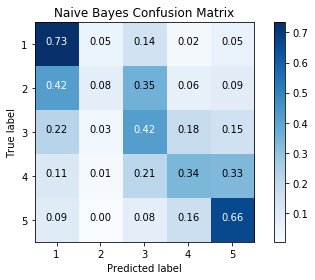

In [112]:
cnf_matrix = confusion_matrix(y_test, y_hat_test_NB)

plt.figure()
helper.plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=True,
                      title='Naive Bayes Confusion Matrix')
plt.show()

In [113]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

[autoreload of helper_functions failed: Traceback (most recent call last):
  File "/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/Users/Kristinabarounis/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/Kristinabarounis/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/Kristinabarounis/Desktop/Data_Science_Projects/Amazon_Reviews_NLP_Project/helper_functions.py", line 79, in <module